In [1]:
# get_ipython().magic('matplotlib notebook')
# get_ipython().magic('matplotlib inline')
# get_ipython().magic('load_ext autoreload')
# get_ipython().magic('autoreload 2')
%matplotlib inline
%load_ext autoreload
%autoreload 2
    
#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import shapefile as shp
import numpy     as np
import xarray    as xr
import time      as clock
import warnings
xr.set_options(keep_attrs=True)
do_parallel   = False
parallel_nprc = 48   # number of dask workers
parallel_tmem = 200  # max. available RAM

/albedo/home/pscholz/tripyview


### INFO:
To compute especially on large unstructured grids #vertices>1M, you need to run this notebook in parallel (do_parallel=True) on several workers (parallel_nprc...is the number of dask worker that can be allocated, parallel_tmem...is the maximum available RAM that will be distributed between the dask workers). Therefor allocate a full !!! COMPUTE NODE !!! (admins might not be happy if you do this in parallel on a login node) of a HPC of your choice with as much memory (RAM) as you can get to run this notebook!

In [2]:
if do_parallel:
    from dask.distributed import Client
    # from dask.diagnostics import ProgressBar
    import dask
    print(' --> memory_limit: {:3.3f} GB'.format(parallel_tmem/(parallel_nprc)))
    ## dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
    client = Client(n_workers=parallel_nprc, threads_per_worker=1, memory_limit='{:3.3f} GB'.format(parallel_tmem/parallel_nprc))
    client

In [3]:
# Parameters
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
# mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/dart_test/'
save_path = None 
save_fname= None

#_____________________________________________________________________________________
which_cycl= None #5 # set None --> take path as in input_paths otherwise add dir of cycle
which_mode= 'hovm'

input_paths= list()
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')
# input_paths.append('/albedo/work/user/pscholz/results/dart_linfs_pc0_ctrl_1/1/')


input_names= list()
# input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')

vname     = 'salt'
year      = [1958, 2019]
# year      = [1958, 1961]
mon, day, record, box, depth = None, None, None, None, None

#_____________________________________________________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None #'/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1/' # None
ref_name  = None #'TKE, ck=0.1' # None
ref_year  = None # [2009,2019]
ref_mon, ref_day, ref_record = None, None, None

#_____________________________________________________________________________________
box_region = list()
box_region.append('global')
# box_region.append('ocean_basins/Arctic_Basin.shp')
# box_region.append('ocean_basins/Eurasian_Basin.shp')
# box_region.append('mpas_region/Canada_Basin.shp')
# box_region.append('mpas_region/North_Atlantic_Ocean.shp')
# box_region.append('mpas_region/Greenland_Sea.shp')
# box_region.append('mpas_region/Irminger_Sea.shp')
# box_region.append('mpas_region/Norwegian_Sea.shp')
# box_region.append('mpas_region/Labrador_Sea.shp')
# box_region.append('mpas_region/North_Pacific_Ocean.shp')
# box_region.append('mpas_region/South_Pacific_Ocean.shp')
# box_region.append('mpas_region/Southern_Ocean.shp')
# box_region.append('mpas_region/Western_Weddell_Sea.shp')

#_____________________________________________________________________________________
which_clim= 'phc3'
clim_path = '/albedo/work/projects/p_fesom/FROM-OLLIE/FESOM2/hydrography/phc3.0/phc3.0_annual.nc'

#_____________________________________________________________________________________
cstr      = 'blue2red'
cnum      = 20
cref      = None #0
crange, cmin, cmax, cfac, climit = None, None, None, None, None
chist, ctresh = True, 0.995

#_____________________________________________________________________________________
ncol      = 2      # number of pannel columns in figure
do_rescale= None
which_dpi = 300
figfac    = [8, 3.5]

In [4]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True)

#______________________________________________________________________________________________________
if (which_cycl is not None) and (which_cycl != "None"): 
    for ii,ipath in enumerate(input_paths):
        input_paths[ii] = os.path.join(ipath,'{:d}/'.format(which_cycl))
        print(ii, input_paths[ii])

    if (ref_path is not None) and (ref_path != "None"): 
        ref_path = os.path.join(ref_path,'{:d}/'.format(which_cycl))
        print('R', ref_path)
                
#______________________________________________________________________________________________________        
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)

# ref_cinfo=None
# if (ref_path is not None) and (ref_path != "None"): 
#     if ref_year   is None: ref_year   = year
#     if ref_mon    is None: ref_mon    = mon
#     if ref_record is None: ref_record = record
#     cinfo['cref']=0.0 
#     ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)
# else:
#     do_reffig=False
    
# #______________________________________________________________________________________________________
# # in case of diff plots
# if (ref_path is not None) and (ref_path != "None"): 
#     if ref_year   is None: ref_year   = year
#     if ref_mon    is None: ref_mon    = mon
#     if ref_record is None: ref_record = record

# #______________________________________________________________________________________________________    
# # concatenate list = list1+list2
# if (ref_path is not None) and (ref_path != "None"): 
#     if isinstance(ref_path, list): 
#         input_paths, input_names = ref_path + input_paths, ref_name + input_names
#     else:    
#         input_paths, input_names = list([ref_path]) + input_paths, list([ref_name]) + input_names
        
#______________________________________________________________________________________________________
# define index regions --> reading shape files
box = list()
shp_path = os.path.join(tpv.__path__[0], 'shapefiles/')
for region in box_region:
    if region == 'global' or isinstance(region,list): box.append(region)
    else: box.append(shp.Reader(os.path.join(shp_path, region)))    

 > found *.pckl file: /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.pckl file: tripyview_fesom2_core2_srt_dep@node_focus0.pckl
___FESOM2 MESH INFO________________________
 > path            = /work/ollie/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________


/albedo/home/pscholz/tripyview/tripyview/sub_mesh.py:139: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  mesh = pickle.load(fid)


In [5]:
#___LOAD CLIMATOLOGY___________________________________________________________________________________
clim_vname = vname
if (vname in ['temp', 'salt', 'pdens'] or 'sigma' in vname): 
    # load climatology and interpolate to fesom grid 
    if   vname=='temp' and  which_clim.lower()=='woa18': clim_vname = 't00an1'
    elif vname=='salt' and  which_clim.lower()=='woa18': clim_vname = 's00an1'
    ts = clock.time()
    clim      = tpv.load_climatology(mesh, clim_path, clim_vname, do_load=False, do_persist=True)
    print(' --> elasped time to load clim: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> clim uses {:3.2f} Gb:'.format(clim.nbytes/(1024**3)))
    
    # create hovmoeller from clim
    ts = clock.time()
    clim_hovm = tpv.load_index_fesom2(mesh, clim, box, do_harithm='wmean')
    print(' --> elasped time to comp. clim hovm.: {:3.2f} min.'.format( (clock.time()-ts)/60  ))   
    for ii, data_ii in enumerate(clim_hovm):
        print(' --> clim_hovm[{:s}] uses {:3.2f} Mb:'.format(clim_hovm[ii][list(clim_hovm[ii].keys())[0]].attrs['boxname'], clim_hovm[ii].nbytes/(1024**2)))
    del(clim)
    print('')
else: raise ValueError('climatology not supported for choosen vname')    
  
list_hovm  = list()
#___LOAD FESOM2 DATA___________________________________________________________________________________
for datapath, descript in zip(input_paths, input_names):
    print(datapath)
    ts = clock.time()
    #__________________________________________________________________________________________________
    # load fesom2 data
    data  = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=year, mon=mon,  descript=descript, 
                                do_tarithm='None', do_zarithm='None', do_info=False, do_load=False, do_persist=True )
    print(' --> elasped time to load data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> data uses {:3.2f} Gb:'.format(data.nbytes/(1024**3)))
    
    #__________________________________________________________________________________________________    
    # check if data where loaded
    if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
    
    #__________________________________________________________________________________________________
    # create hovmoeller from data
    ts = clock.time()
    data_hovm = tpv.load_index_fesom2(mesh, data, box, do_harithm='wmean')
    del(data)

    # compute anomalous hovmoeller with respect to climatology
    data_hovm = tpv.do_indexanomaly(data_hovm, clim_hovm)
    print(' --> elasped time to comp. data hovm.: {:3.2f} min.'.format( (clock.time()-ts)/60  ))   
    for ii, data_ii in enumerate(data_hovm):
        print(' --> data_hovm[{:s}] uses {:3.2f} Mb:'.format(data_hovm[ii][list(data_hovm[ii].keys())[0]].attrs['boxname'], data_hovm[ii].nbytes/(1024**2)))
    list_hovm.append(data_hovm)
    del(data_hovm)

 --> elasped time to load clim: 0.01 min.
 --> clim uses 0.05 Gb:
 --> elasped time to comp. clim hovm.: 0.00 min.
 --> clim_hovm[global] uses 0.00 Mb:

/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/


/albedo/home/pscholz/.conda/envs/py38/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


 --> elasped time to load data: 0.69 min.
 --> data uses 1.40 Gb:
 --> elasped time to comp. data hovm.: 0.00 min.
 --> data_hovm[global] uses 0.01 Mb:


/albedo/home/pscholz/.conda/envs/py38/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


--> histo: cmin, cmax =  -0.05829397216439247 0.13938774168491364
{'cstr': 'blue2red', 'cnum': 20, 'chist': True, 'ctresh': 0.995, 'cmin': -0.058, 'cmax': 0.139, 'cref': 0.04, 'cmap': <matplotlib.colors.ListedColormap object at 0x14eca993ee80>, 'clevel': array([-0.06 , -0.055, -0.05 , -0.045, -0.04 , -0.035, -0.03 , -0.025,
       -0.02 , -0.015, -0.01 , -0.005,  0.   ,  0.005,  0.01 ,  0.015,
        0.02 ,  0.025,  0.03 ,  0.035,  0.04 ,  0.045,  0.05 ,  0.055,
        0.06 ,  0.065,  0.07 ,  0.075,  0.08 ,  0.085,  0.09 ,  0.095,
        0.1  ,  0.105,  0.11 ,  0.115,  0.12 ,  0.125,  0.13 ,  0.135,
        0.14 ])}


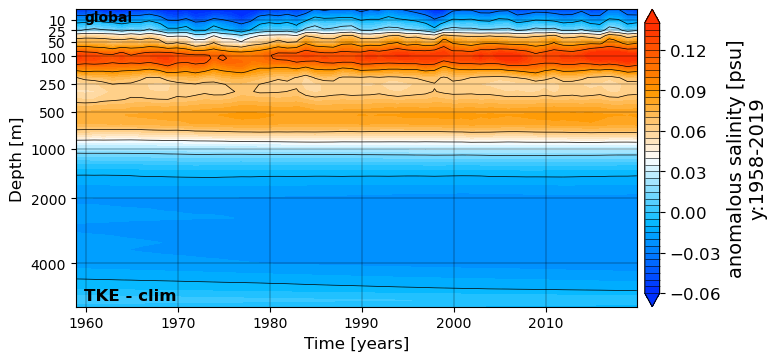

In [6]:
#___PLOT HOVM__________________________________________________________________________________________
spath  = save_path
sname  = vname
ncol   = np.min([ncol,len(list_hovm)])    
nrow   = np.ceil(len(list_hovm)/ncol).astype('int')
for ii in range(len(box)):
    slabel = list_hovm[0][ii][sname].attrs['str_lsave']
    sbox   = list_hovm[0][ii][vname].attrs['boxname'].replace(' ','_').lower()
    if spath is not None: spath  = '{}/{}_{}_{}_{}.png'.format(spath, which_mode, sname, sbox, slabel) 
    if save_fname is not None: spath = save_fname
    cinfo2 = cinfo.copy()    
    fig, ax, cbar = tpv.plot_index_hovm(list_hovm, boxidx=ii, cinfo=cinfo2, figsize=[ncol*figfac[0], nrow*figfac[1]], n_rc=[nrow, ncol], 
                                        do_rescale=do_rescale, pos_gap=[0.01, 0.01], pos_extend=[0.05, 0.05, 0.85,0.90], 
                                        do_save = spath, save_dpi=which_dpi )